# Detecting bullying Tweets with PyTorch LSTM + Attention and BERT Transformer Project

This project is about the analysis of tweets about cyberbullying, with the goal of performing a Sentiment Analysis using LSTM w/ Attention and BERT on PyTorch to predict if a tweet is about cyberbullying or not. <br>
In particular, bullying tweets are divided in 4 categories: religion, age, race and gender.<br>
The project is divided in the following sections:

- Data Import
- Text cleaning with custom defined functions
- Naive Bayes baseline model Classifier
- Data preparation for LSTM RNN: Tokenization
- PyTorch LSTM RNN Classifier w/ Attention
- Data preparation for BERT: Tokenization
- PyTorch BERT Classifier
- Results summary

Similar NLP notebooks I made:
- Twitter Sentiment Analysis with BERT + RoBERTa on COVID related tweets:<br>
    https://www.kaggle.com/ludovicocuoghi/twitter-sentiment-analysis-with-bert-roberta

- Twitter Sentiment Analysis with non-labeled tweets about Omicron with using Vader, NLTK, TextBLOB and Flair:<br>
    https://www.kaggle.com/ludovicocuoghi/how-are-people-reacting-to-omicron-on-twitter

# Main results summary:

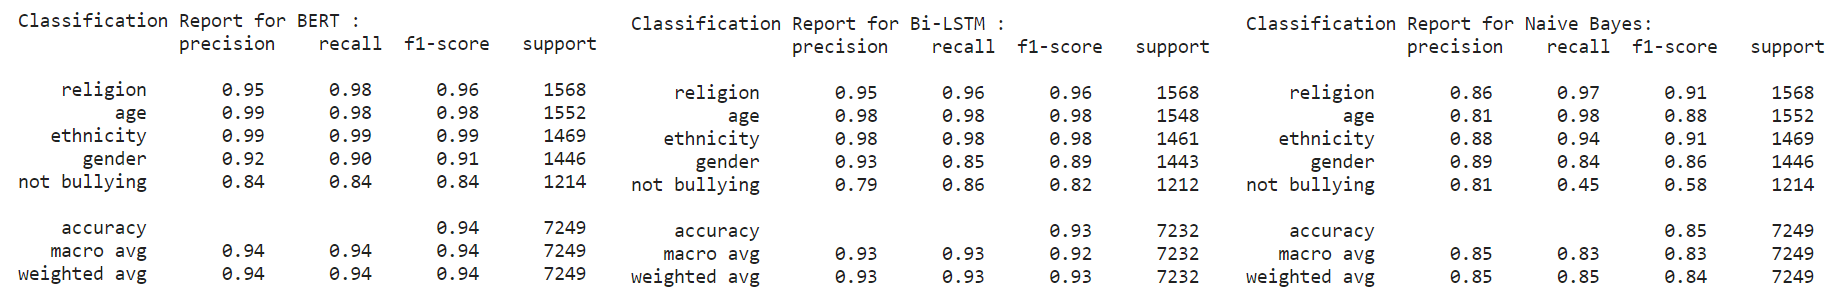

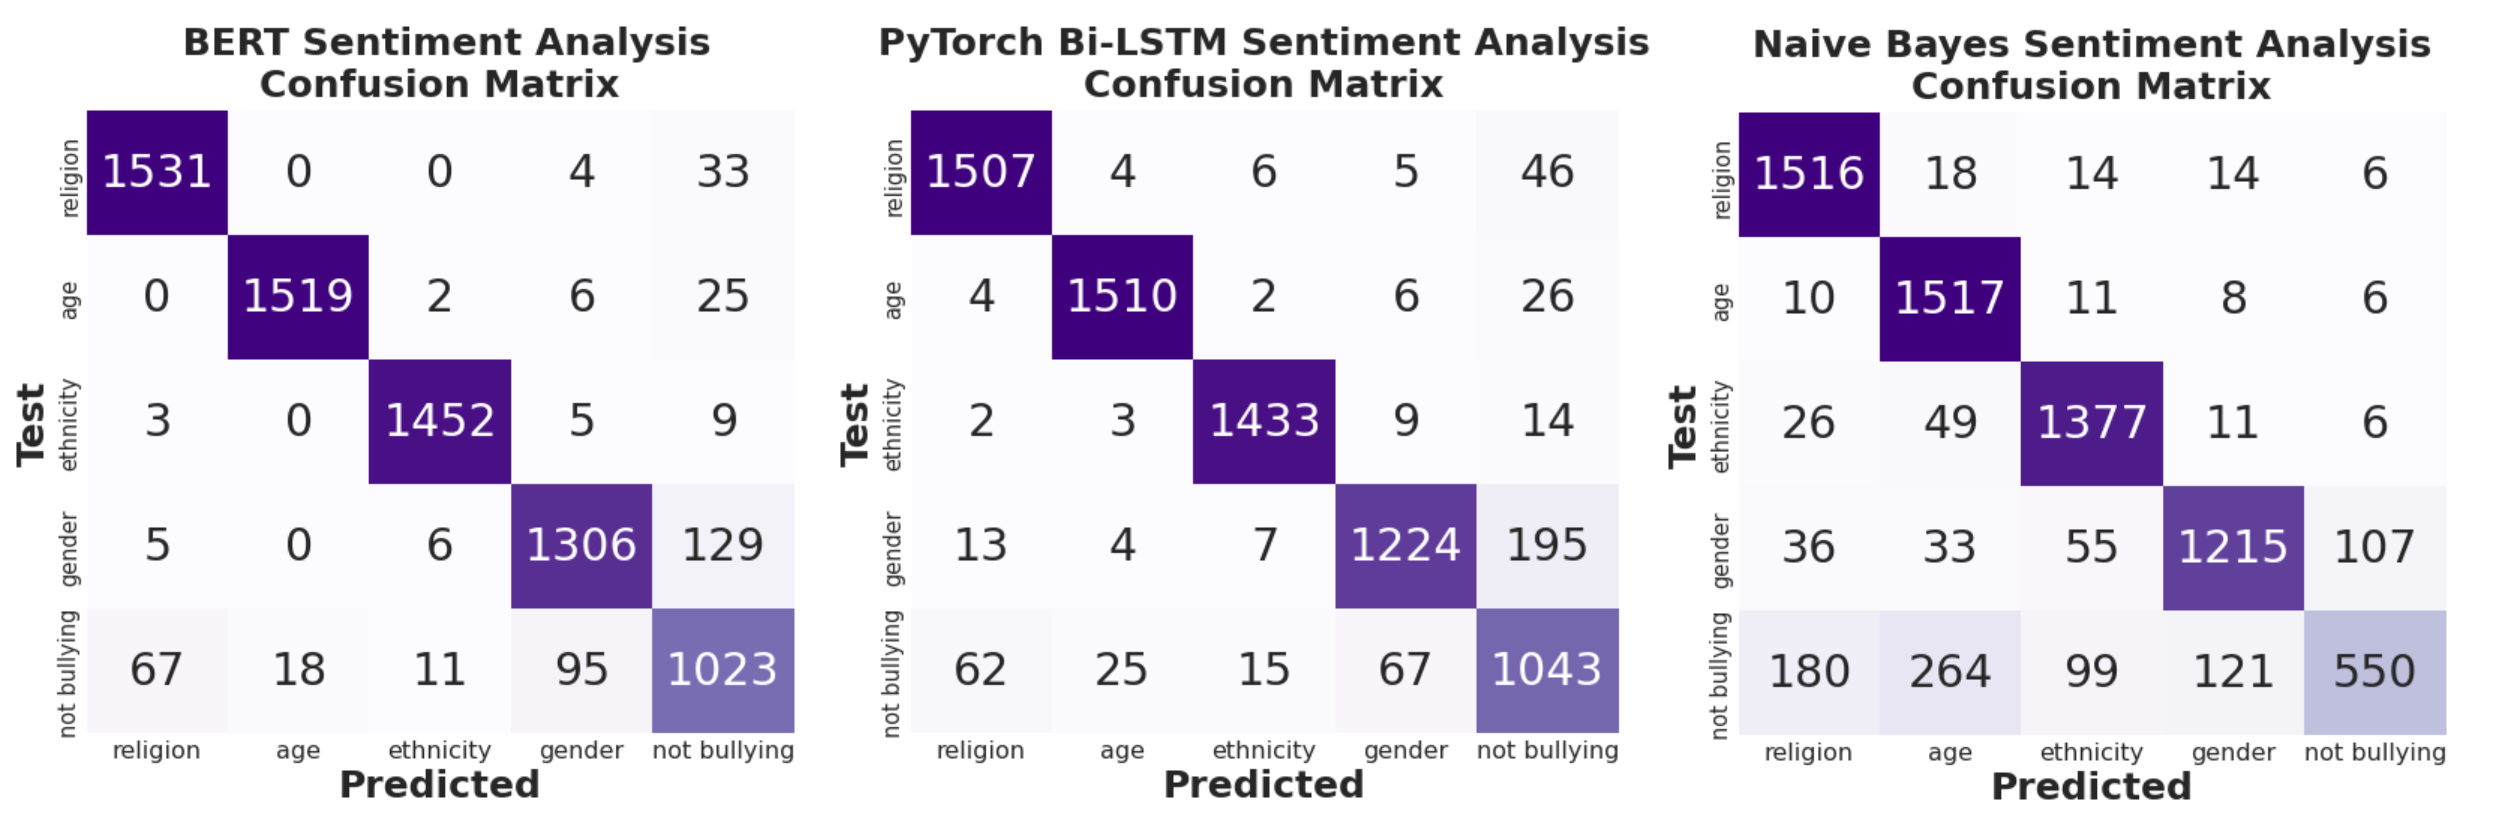

**Naive Bayes baseline classifier performed quite well on the dataset, with an overall accuracy of 87% among all the classes.<br>
On the other hand, the custom LSTM w/ attention RNN by PyTorch achieved an accuracy of 93%, where some classes have F1 score over 95%.**<br>
**Finally, BERT performed the best, with an overall accuracy around 95% and F1 scores over 96%.**<br>
Overall, the algorithms could properly distinguish the different topics of the bullying tweets, and had little **more troubles** with the **less populated class "not cyberbullying" and the "gender" class (achieving lower precision and recall compared to other classes)**.<br>
For this reason, it could be a good idea to **collect more data of this classes** and aim to achieve higher accuracy and F1 score.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv


## Custom functions definition:

In [1]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [2]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install contractions

  Obtaining dependency information for contractions from https://files.pythonhosted.org/packages/bb/e4/725241b788963b460ce0118bfd5c505dd3d1bdd020ee740f9f39044ed4a7/contractions-0.1.73-py2.py3-none-any.whl.metadata
  Obtaining dependency information for textsearch>=0.0.21 from https://files.pythonhosted.org/packages/e2/0f/6f08dd89e9d71380a369b1f5b6c97a32d62fc9cfacc1c5b8329505b9e495/textsearch-0.0.24-py2.py3-none-any.whl.metadata
  Obtaining dependency information for anyascii from https://files.pythonhosted.org/packages/4f/7b/a9a747e0632271d855da379532b05a62c58e979813814a57fa3b3afeb3a4/anyascii-0.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for pyahocorasick from https://files.pythonhosted.org/packages/31/32/17ab57fe5abcf09d2f1ceb502143447be00658761d167118441e19a2b2c6/pyahocorasick-2.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.2 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━

In [38]:
!pip install scikit-learn==1.2.2

  Obtaining dependency information for scikit-learn==1.2.2 from https://files.pythonhosted.org/packages/4c/64/a1e6e92b850b39200c82e3bc54d556b2c634b3904c39ac5cdb10b1c5765f/scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 12.2 MB/s eta 0:00:00m eta 0:00:010:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


## Import libraries

In [3]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

/home/mb05005/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/tmp/ipykernel_187847/1129029219.py:41: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mb05005/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mb05005/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<Figure size 640x480 with 0 Axes>

## Data Import

In [4]:
df = pd.read_csv("cyberbullying_tweets.csv")

In [5]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


First we rename the columns using shorter words for easier reference.

In [7]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

### Are there duplicated tweets?

In [8]:
df.duplicated().sum()

36

There are some duplicated tweets, we will remove them.

In [9]:
df = df[~df.duplicated()]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47656 non-null  object
 1   sentiment  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


### Are the classes balanced?

In [11]:
df.sentiment.value_counts()

sentiment
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

The classes look balanced.

# Tweets text deep cleaning

Next, we will define custom functions to clean the texts of the tweets.

In [12]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.get_emoji_regexp().sub("", text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [14]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [15]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


### Are there duplicate tweets after the cleaning?

In [16]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 6276 duplicated tweets, we will remove them.


In [17]:
df.drop_duplicates("text_clean", inplace=True)

We removed the duplicated cleaned tweets. How is the class balance after the cleaning?

In [18]:
df.sentiment.value_counts()

sentiment
religion               7912
age                    7817
ethnicity              7410
gender                 7280
not_cyberbullying      6065
other_cyberbullying    4896
Name: count, dtype: int64

We can see that lots of tweets of the class "other_cyberbullying" have been removed. Since the class is very unbalanced compared to the other classes and looks too "generic", we decide to remove the tweets labeled belonging to this class.<br>
EDIT: by performing some tests, the f1 score for predicting the "other_cyberbullying" resulted to be around 60%, a value far lower compared to the othter f1 scores (around 95% using LSTM model). This supports the decision of removing this generic class.

In [19]:
df = df[df["sentiment"]!="other_cyberbullying"]

Then we also define a list of the classes names, which will be useful for the future plots.

In [20]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

# Tweets length analysis

Now we will define a new dataframe column containing the length of the cleaned tweets in terms of number of words.

In [21]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

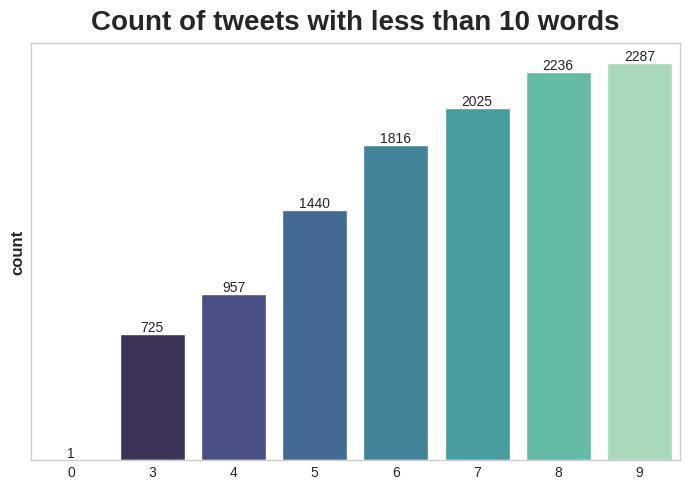

In [22]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

### What about long tweets?

In [23]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white trying live like nigger pahahahaha...,173
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb as nigger bitch ltthis whore s...,151
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,researcher push import top antibullying progra...,138
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilty killing feel guilty enjoyed tormen...,136
10922,don't make rape jokes!!! don't make gay jokes!...,gender,make rape joke make gay joke oh fat joke okay ...,121
...,...,...,...,...
1425,But I won't the bloody blondes to stay.,not_cyberbullying,bloody blonde stay,3
35870,"0, would bully u at school",age,would bully school,3
4252,Yess SR...Romeo's voice,not_cyberbullying,yes srromeos voice,3
3350,@LynnMagic some of it. Many moving parts.,not_cyberbullying,many moving part,3


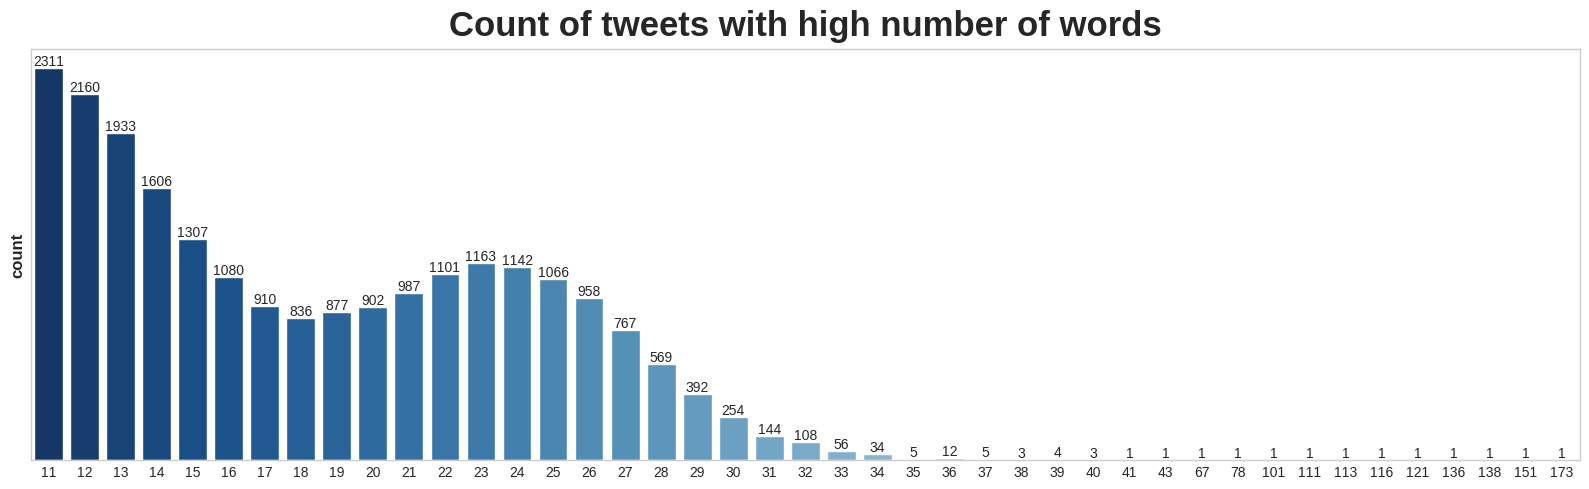

In [24]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We also will remove tweets that are too long (with more than 100 words).

In [25]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

Then we also get the length of the longest tweet since it will be useful later.

In [26]:
max_len = np.max(df['text_len'])
max_len 

31

In [27]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
11992,"Since Jun, Hong Kong Police terrorists brutali...",gender,since jun hong kong police terrorist brutalize...,31
22532,If something is bad then it is bad. Donnow wy ...,religion,something bad bad donnow wy people compare oth...,31
38338,He's relatable to teens. He's a kid in High sc...,age,relatable teen kid high school trying get get ...,31
34752,How about if we got different girls on the bac...,age,got different girl bachelor show girl short ha...,31
39523,Amanda is a former shy fat girl from high scho...,age,amanda former shy fat girl high school bullied...,31
...,...,...,...,...
2534,@cxarli nope. I had to manually block her.,not_cyberbullying,nope manually block,3
8010,@EqualityMen The motive doesn't lessen the out...,gender,motive lessen outcome,3
8037,Kat is a sociopath #mkr,gender,kat sociopath mkr,3
7643,Bully - missed this game.,not_cyberbullying,bully missed game,3


## Sentiment column encoding

The target column will be encoded by ordinal encoding

In [28]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

## Train - Test split

Now we need to split the dataset into a train and test sets.

In [29]:
X = df['text_clean']
y = df['sentiment']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

## Train - Validation split

Moreover, we will further split the training set to extract a validation set, which will be used to monior the accuracy and loss to avoid overfitting during the model training.

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [32]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5012],
       [   1, 4968],
       [   2, 4705],
       [   3, 4628],
       [   4, 3880]])

The classes are unbalanced, so it could be a good idea to oversample the training set such that all classes have the same count as the most populated one.

# Oversampling of training set

In [33]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [34]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [35]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5012],
       [   1, 5012],
       [   2, 5012],
       [   3, 5012],
       [   4, 5012]])

# BERT Classification

In this section, we will load a pre trained BERT model from the Hugging Face library and fine tune it for our classification task.

First, we need to split the dataset into train - validation - test again since we need to tokenize the sentences differently from before (Naive Bayes and LSTM).

## Train - Validation - Test split

In [36]:
X = df['text_clean'].values
y = df['sentiment'].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

As seen before, we oversample the text to the majority class.

In [39]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [40]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [41]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5012],
       [   1, 5012],
       [   2, 5012],
       [   3, 5012],
       [   4, 5012]])

# BERT Tokenization

Since we need to tokenize the tweets (get "input ids" and "attention masks") for BERT, we load the specific BERT tokenizer from the Hugging Face library.

In [42]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Then we define a custom tokenizer function using the loaded tokenizer.

In [43]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            padding=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Since we need to specify the length of the longest tokenized sentence, we tokenize the train tweets using the "encode" method of the original BERT tokenizer and check the longest sentence.

In [44]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  82


We can choose the max length as 128.

In [45]:
MAX_LEN = 128

Then we can tokenize the train, validation and test tweets using the custom define tokenizer.

In [48]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

## Data preprocessing for PyTorch BERT model

Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create dataloaders for the data.

In [49]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

## Dataloaders

To fine-tune the BERT model, the original authors recommend a batch size of 16 or 32.

In [50]:
batch_size = 32

In [53]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# BERT Modeling

Now we can create a custom BERT classifier class, including the original BERT model (made of transformer layers) and additional Dense layers to perform the desired classification task.

In [54]:
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Moreover, since we want to define a learning rate scheduler, we define a custom "initalize_model" function as follows.

In [55]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)

    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

We also specify the use of GPU if present (highly recommended for the fine tuning)

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

And then we intialize the BERT model calling the "initialize_model" function we defined.

In [57]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

/home/mb05005/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# BERT Training

After defining the custom BERT classifier model, we are ready to start the training.

In [58]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [59]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.577783   |   20.53  
   200    |   0.283692   |   19.56  
   300    |   0.253134   |   19.75  
   400    |   0.231703   |   20.30  
   500    |   0.211124   |   20.26  
   600    |   0.197229   |   20.26  
   700    |   0.187508   |   20.27  
   783    |   0.162786   |   16.73  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.265697    |  0.189621  |       93.92       |  170.11  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.132794   |   20.75  
   200    |   0.141404   |   20.71  
   3

In [61]:
torch.save(bert_classifier.state_dict(), 'bert_model.pth')

In [62]:
# Load the trained model from a file
def load_model(model, file_path="bert_model.pth"):
    """
    Load the state dictionary into the model.

    Args:
        model: The model architecture into which the state dictionary will be loaded.
        file_path: File path of the saved model.
    """
    model.load_state_dict(torch.load(file_path))
    model.eval()  # Set to evaluation mode
    print(f"Model loaded from {file_path}")
    return model

# Example usage
# Assuming `model` is the same architecture as used during training
model = load_model(bert_classifier, file_path="bert_model.pth")

/tmp/ipykernel_187847/2174492707.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))


Model loaded from bert_model.pth


# BERT Prediction

Now we define a function similar to the model "evaluation", where we feed to the model the test data instead of the validation data.

In [63]:
def bert_predict(model, test_dataloader):
    
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

Then we can call the defined function and get the class predictions of the test data.

In [64]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [65]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.96      0.97      0.97      1567
         age       0.99      0.98      0.98      1553
   ethnicity       0.99      0.99      0.99      1470
      gender       0.93      0.91      0.92      1447
not bullying       0.85      0.85      0.85      1212

    accuracy                           0.95      7249
   macro avg       0.94      0.94      0.94      7249
weighted avg       0.95      0.95      0.95      7249



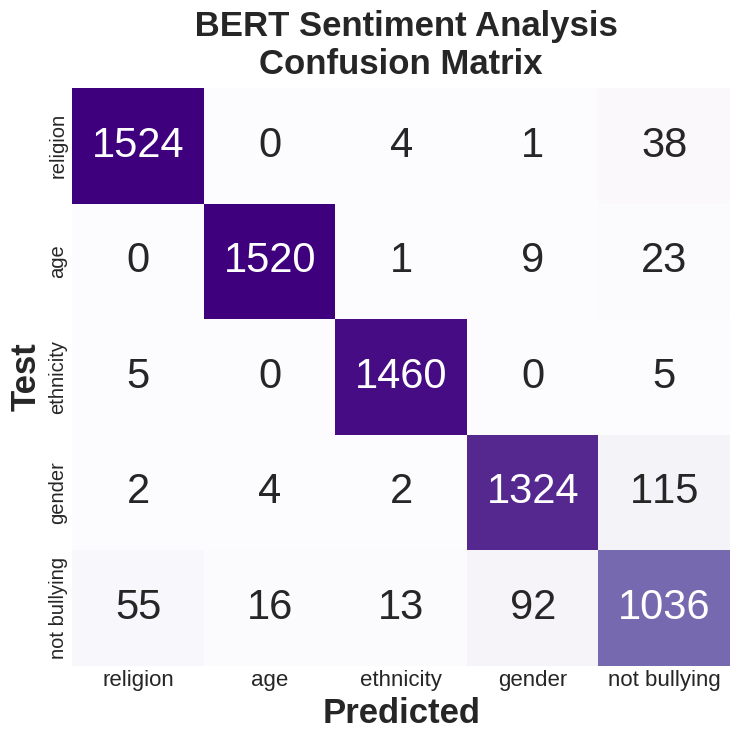

In [66]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of BERT Classifier are quite high and higher than those achieved using the LSTM model, with an overall accuracy around 95% and F1 scores well over 95%.**<br>

Thank your for checking out my notebook! Let me know if you have comments or if you want me to check out your work! :)

In [68]:
br_data = pd.read_csv('brandwatch_data.csv',usecols=['Title', 'Sentiment', 'Emotion', 'Region', 'Gender', 'Impressions'])
br_data.head()

,Title,Sentiment,Emotion,Region,Gender,Impressions
0,@realest_lauren @KellyScaletta Close our borde...,negative,Anger,Florida,male,358
1,@wow36932525 Didn't Michael Herrera talk about...,negative,NaN,Oregon,unknown,280
2,@KatiePhang FOR ALL OF YOU ILLITERATE DUMMIES ...,negative,Joy,Texas,unknown,5
3,@vickiringer The border patrol couldn’t legall...,negative,Sadness,California,male,75
4,@tuszyb Another dumbed down individual. THIS H...,negative,NaN,Texas,unknown,5


In [69]:
texts = br_data['Title'].tolist()
len(texts)

74630

In [76]:
def predictions(model, texts, tokenizer, max_len=128, batch_size=32, device='cuda'):
    """
    Predict classes for the given list of texts in batches without using a DataLoader.
    
    Args:
        model: Trained PyTorch model.
        texts: List of input strings to classify.
        tokenizer: Tokenizer used to encode the inputs.
        max_len: Maximum length of input sequences.
        batch_size: Number of texts to process in each batch.
        device: Device to run the predictions ('cpu' or 'cuda').
    
    Returns:
        preds_list: List of predicted class indices.
    """
    preds_list = []

    # Process in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i + batch_size]
        
        # Use the existing bert_tokenizer to tokenize the batch
        input_ids, attention_masks = bert_tokenizer(batch_texts)
        
        # Move tensors to the specified device
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        
        # Put the model into evaluation mode
        model.eval()
        
        # Perform predictions
        with torch.no_grad():
            logits = model(input_ids, attention_masks)  # Forward pass
            preds = torch.argmax(logits, dim=1).cpu().numpy()  # Get class predictions
            preds_list.extend(preds)
    
    return preds_list

In [77]:
predictions = predictions(bert_classifier, texts, tokenizer, max_len=128, batch_size=32, device='cuda')
print(f"Predictions: {predictions}")

/home/mb05005/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predictions: [2, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 4, 4, 2, 2, 2, 4, 2, 4, 4, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 4, 4, 2, 4, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 4, 4, 2, 4, 4, 4, 2, 2, 2, 2, 4, 2, 2, 0, 4, 4, 2, 2, 4, 4, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 0, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 4, 4, 2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 4, 2, 4, 4, 2, 4, 2, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 4, 2, 2, 2,

In [78]:
# Dictionary mapping numeric predictions to labels
label_map = {'religion': 0, 'age': 1, 'ethnicity': 2, 'gender': 3, 'not_cyberbullying': 4}
inverse_label_map = {v: k for k, v in label_map.items()}  # Reverse the dictionary for mapping numbers to strings

# Replace numeric predictions with their corresponding string labels
predictions_labels = [inverse_label_map[pred] for pred in predictions]

# Add the predictions as a new column in the DataFrame
br_data['predictions'] = predictions_labels

# Display the updated DataFrame
br_data.head()

,Title,Sentiment,Emotion,Region,Gender,Impressions,predictions
0,@realest_lauren @KellyScaletta Close our borde...,negative,Anger,Florida,male,358,ethnicity
1,@wow36932525 Didn't Michael Herrera talk about...,negative,NaN,Oregon,unknown,280,ethnicity
2,@KatiePhang FOR ALL OF YOU ILLITERATE DUMMIES ...,negative,Joy,Texas,unknown,5,ethnicity
3,@vickiringer The border patrol couldn’t legall...,negative,Sadness,California,male,75,not_cyberbullying
4,@tuszyb Another dumbed down individual. THIS H...,negative,NaN,Texas,unknown,5,ethnicity


In [81]:
br_data['predictions'].value_counts()

predictions
ethnicity            51358
not_cyberbullying    17888
religion              3994
gender                 710
age                    680
Name: count, dtype: int64

In [82]:
br_data.to_csv("BERT_Brandwatch.csv",index=False)